In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DAICON 쇼핑몰 지점별 매출액 예측 경진대회

발표자 강인구 

#1. EDA

In [4]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Dataset/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')

In [5]:
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [ ]:
train.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


Promotion 같은 경우 행사에 따른 정보로 float 형태인 것을 보아 데이터 값이 행사로 인한 판매량이나 판매금액 또는 퍼센트를 알려주는 것인 것을 알 수 있다.

In [6]:
train=train.fillna(0)
test=test.fillna(0)
sample_submission=sample_submission.fillna(0)

In [7]:
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,False,1554806.68


In [8]:
def toDateTime(df):
  df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
  return df

In [9]:
train= toDateTime(train)
test = toDateTime(test)

In [10]:
train.sort_values(by =['Date'], inplace= True, ascending= False)
train[train['Store']==1].head(28)

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
138,139,1,2012-09-28,76.08,3.666,3666.27,7.64,1.65,1417.96,4744.28,6.908,False,1437059.26
137,138,1,2012-09-21,69.87,3.721,6352.30,7.64,4.69,1010.06,6456.71,6.908,False,1506126.06
136,137,1,2012-09-14,74.97,3.717,17212.52,7.00,18.79,1523.11,7992.72,6.908,False,1517428.87
135,136,1,2012-09-07,83.96,3.730,5204.68,35.74,50.94,4120.32,2737.17,6.908,True,1661767.33
134,135,1,2012-08-31,80.49,3.638,21442.73,102.32,21.70,13209.64,3032.96,6.908,False,1582083.40
133,134,1,2012-08-24,77.66,3.620,6237.83,260.06,2.97,3463.03,7988.25,6.908,False,1494122.38
132,133,1,2012-08-17,84.85,3.571,3662.06,137.86,4.84,2752.20,3446.15,6.908,False,1597868.05
131,132,1,2012-08-10,85.05,3.494,11436.22,245.00,6.85,6964.26,4836.22,6.908,False,1592409.97
130,131,1,2012-08-03,86.11,3.417,27584.78,119.98,30.23,12007.04,4661.71,6.908,False,1631135.79
129,130,1,2012-07-27,82.66,3.407,7146.90,389.02,1.59,10267.54,4325.19,6.908,False,1439123.71


In [11]:
train.sort_values(by =['Date'], inplace= True, ascending= True)
train[train['Store']==1].head(30)

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,False,1643690.90
1,2,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,True,1641957.44
2,3,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,False,1611968.17
3,4,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,False,1409727.59
4,5,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,False,1554806.68
5,6,1,2010-03-12,57.79,2.667,0.0,0.0,0.0,0.0,0.0,8.106,False,1439541.59
6,7,1,2010-03-19,54.58,2.720,0.0,0.0,0.0,0.0,0.0,8.106,False,1472515.79
7,8,1,2010-03-26,51.45,2.732,0.0,0.0,0.0,0.0,0.0,8.106,False,1404429.92
8,9,1,2010-04-02,62.27,2.719,0.0,0.0,0.0,0.0,0.0,7.808,False,1594968.28
9,10,1,2010-04-09,65.86,2.770,0.0,0.0,0.0,0.0,0.0,7.808,False,1545418.53


여기서 데이터는 2010-02-05부터 2012-09-28까지의 조사한 것을 알 수 있다 즉 해당 숫자에서 한 20퍼센트만 validation 값으로 넣는다

In [12]:
train['Date'].value_counts()

2010-02-05    45
2011-12-02    45
2011-10-21    45
2011-10-28    45
2011-11-04    45
              ..
2010-11-12    45
2010-11-05    45
2010-10-29    45
2010-10-22    45
2012-09-28    45
Name: Date, Length: 139, dtype: int64

In [13]:
train['Date'].sort_values()

0      2010-02-05
4448   2010-02-05
1807   2010-02-05
4587   2010-02-05
6116   2010-02-05
          ...    
277    2012-09-28
3057   2012-09-28
5142   2012-09-28
416    2012-09-28
6254   2012-09-28
Name: Date, Length: 6255, dtype: datetime64[ns]

해당 지점수 만큼 공통된 날짜를 가지고 있고 데이트는 139의 데이터가 있으니 



In [14]:
cutOff = pd.to_datetime('2012-03-23')
trains = train[train['Date'] < cutOff]
vals = train[(train['Date'] >= cutOff)]


In [15]:
trains.shape, vals.shape

((4995, 13), (1260, 13))

#**해당 dataset분석**

##1. train.csv : 학습 데이터

*  id : 샘플 아이디

*  Store : 쇼핑몰 지점

*  Date : 주 단위(Weekly) 날짜

*  Temperature : 해당 쇼핑몰 주변 기온(F)

*  Fuel_Price : 해당 쇼핑몰 주변 연료 가격

*  Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보

*  Unemployment : 해당 쇼핑몰 지역의 실업률

*  IsHoliday : 해당 기간의 공휴일 포함 여부

*  Weekly_Sales : 주간 매출액 (목표 예측값)


##2. test.csv : 테스트 데이터

*  id : 샘플 아이디

*  Store : 쇼핑몰 지점

*  Date : 주 단위(Weekly) 날짜

*  Temperature : 해당 쇼핑몰 주변 기온(F)

*  Fuel_Price : 해당 쇼핑몰 주변 연료 가격

*  Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보

*  Unemployment : 해당 쇼핑몰 지역의 실업률

*  IsHoliday : 해당 기간의 공휴일 포함 여부

##3. Target : Weekly_Sales 


In [16]:
def Date_to_int(train):
  train['Date'] = train['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  train['Date'] = train['Date'].astype(int)
  return train

In [17]:
trains = Date_to_int(trains)
vals = Date_to_int(vals)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
target = 'Weekly_Sales'

## X_train, y_train, X_test, y_test 데이터로 분리
X_train = trains.drop(columns=target)
y_train = trains[target]
X_val = vals.drop(columns=target)
y_val = vals[target]

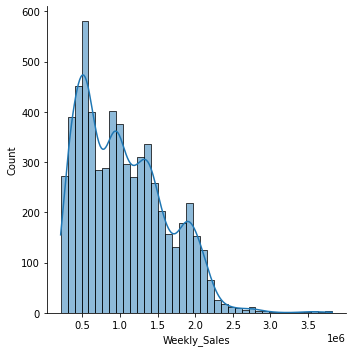

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(train['Weekly_Sales'],kde=True);

In [20]:
from sklearn.feature_selection import f_regression, SelectKBest
## selctor 정의합니다.
selector = SelectKBest(score_func=f_regression, k=7)

## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)

## 테스트 데이터는 transform
X_val_selected = selector.transform(X_val)


X_train_selected.shape, X_val_selected.shape

((4995, 7), (1260, 7))

In [21]:
all_names = X_train.columns

## selector.get_support()
selected_mask = selector.get_support()

## 선택된 특성들
selected_names = all_names[selected_mask]

## 선택되지 않은 특성들
unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['id', 'Store', 'Promotion1', 'Promotion3', 'Promotion4', 'Promotion5',
       'Unemployment'],
      dtype='object')
Unselected names:  Index(['Date', 'Temperature', 'Fuel_Price', 'Promotion2', 'IsHoliday'], dtype='object')


In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5

In [23]:
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_train_selected)
rmse = RMSE(y_train, y_pred)
y_pred = model.predict(X_val_selected)
rmse = RMSE(y_val, y_pred)


In [24]:
print("RMSE : ",rmse)

RMSE :  468796.1597784946


선형 회귀 기존으로는 문제가 많다 한번 더 다른 실험을 해보자. 


문제가 많은 이유 : 선택된 특성이 모델의 결과에 제대로 반영되지 못했다

In [27]:
train.Store.value_counts(sort=True)

1     139
42    139
33    139
14    139
34    139
45    139
35    139
12    139
36    139
11    139
37    139
5     139
38    139
9     139
39    139
8     139
40    139
7     139
2     139
41    139
6     139
15    139
32    139
44    139
43    139
3     139
16    139
31    139
13    139
21    139
25    139
28    139
22    139
29    139
23    139
19    139
20    139
18    139
24    139
30    139
27    139
17    139
26    139
4     139
10    139
Name: Store, dtype: int64

즉 모든 지점의 고유한 데이터 값은 139개이다. 

추가적으로 

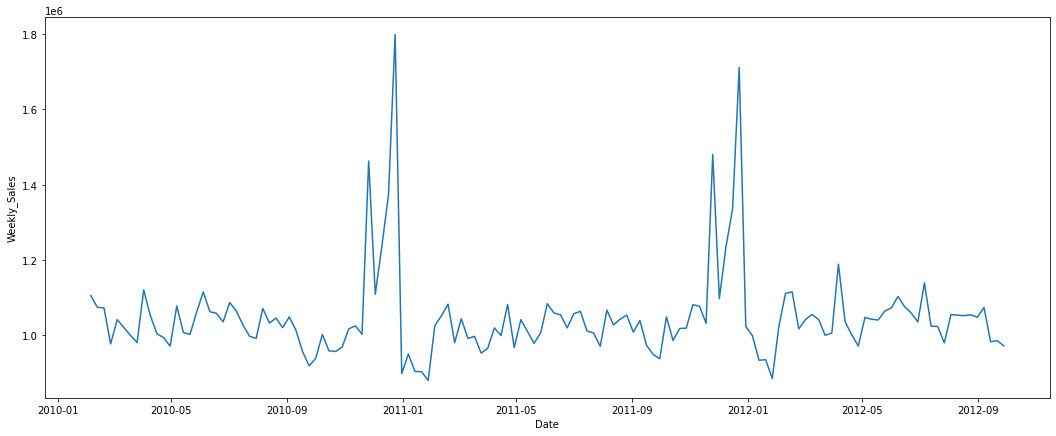

In [28]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=train, x="Date", y="Weekly_Sales", ci=None)
plt.show()

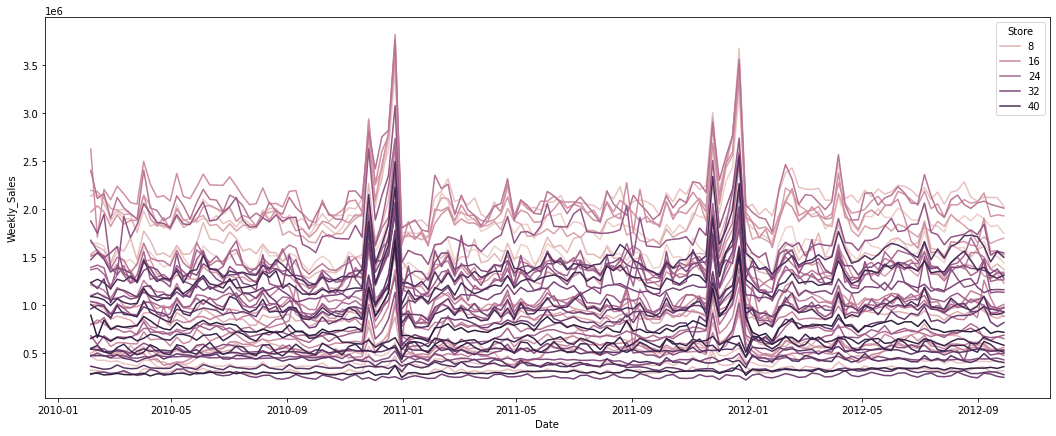

In [29]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=train, x="Date", y="Weekly_Sales", ci=None, hue="Store")
plt.show()

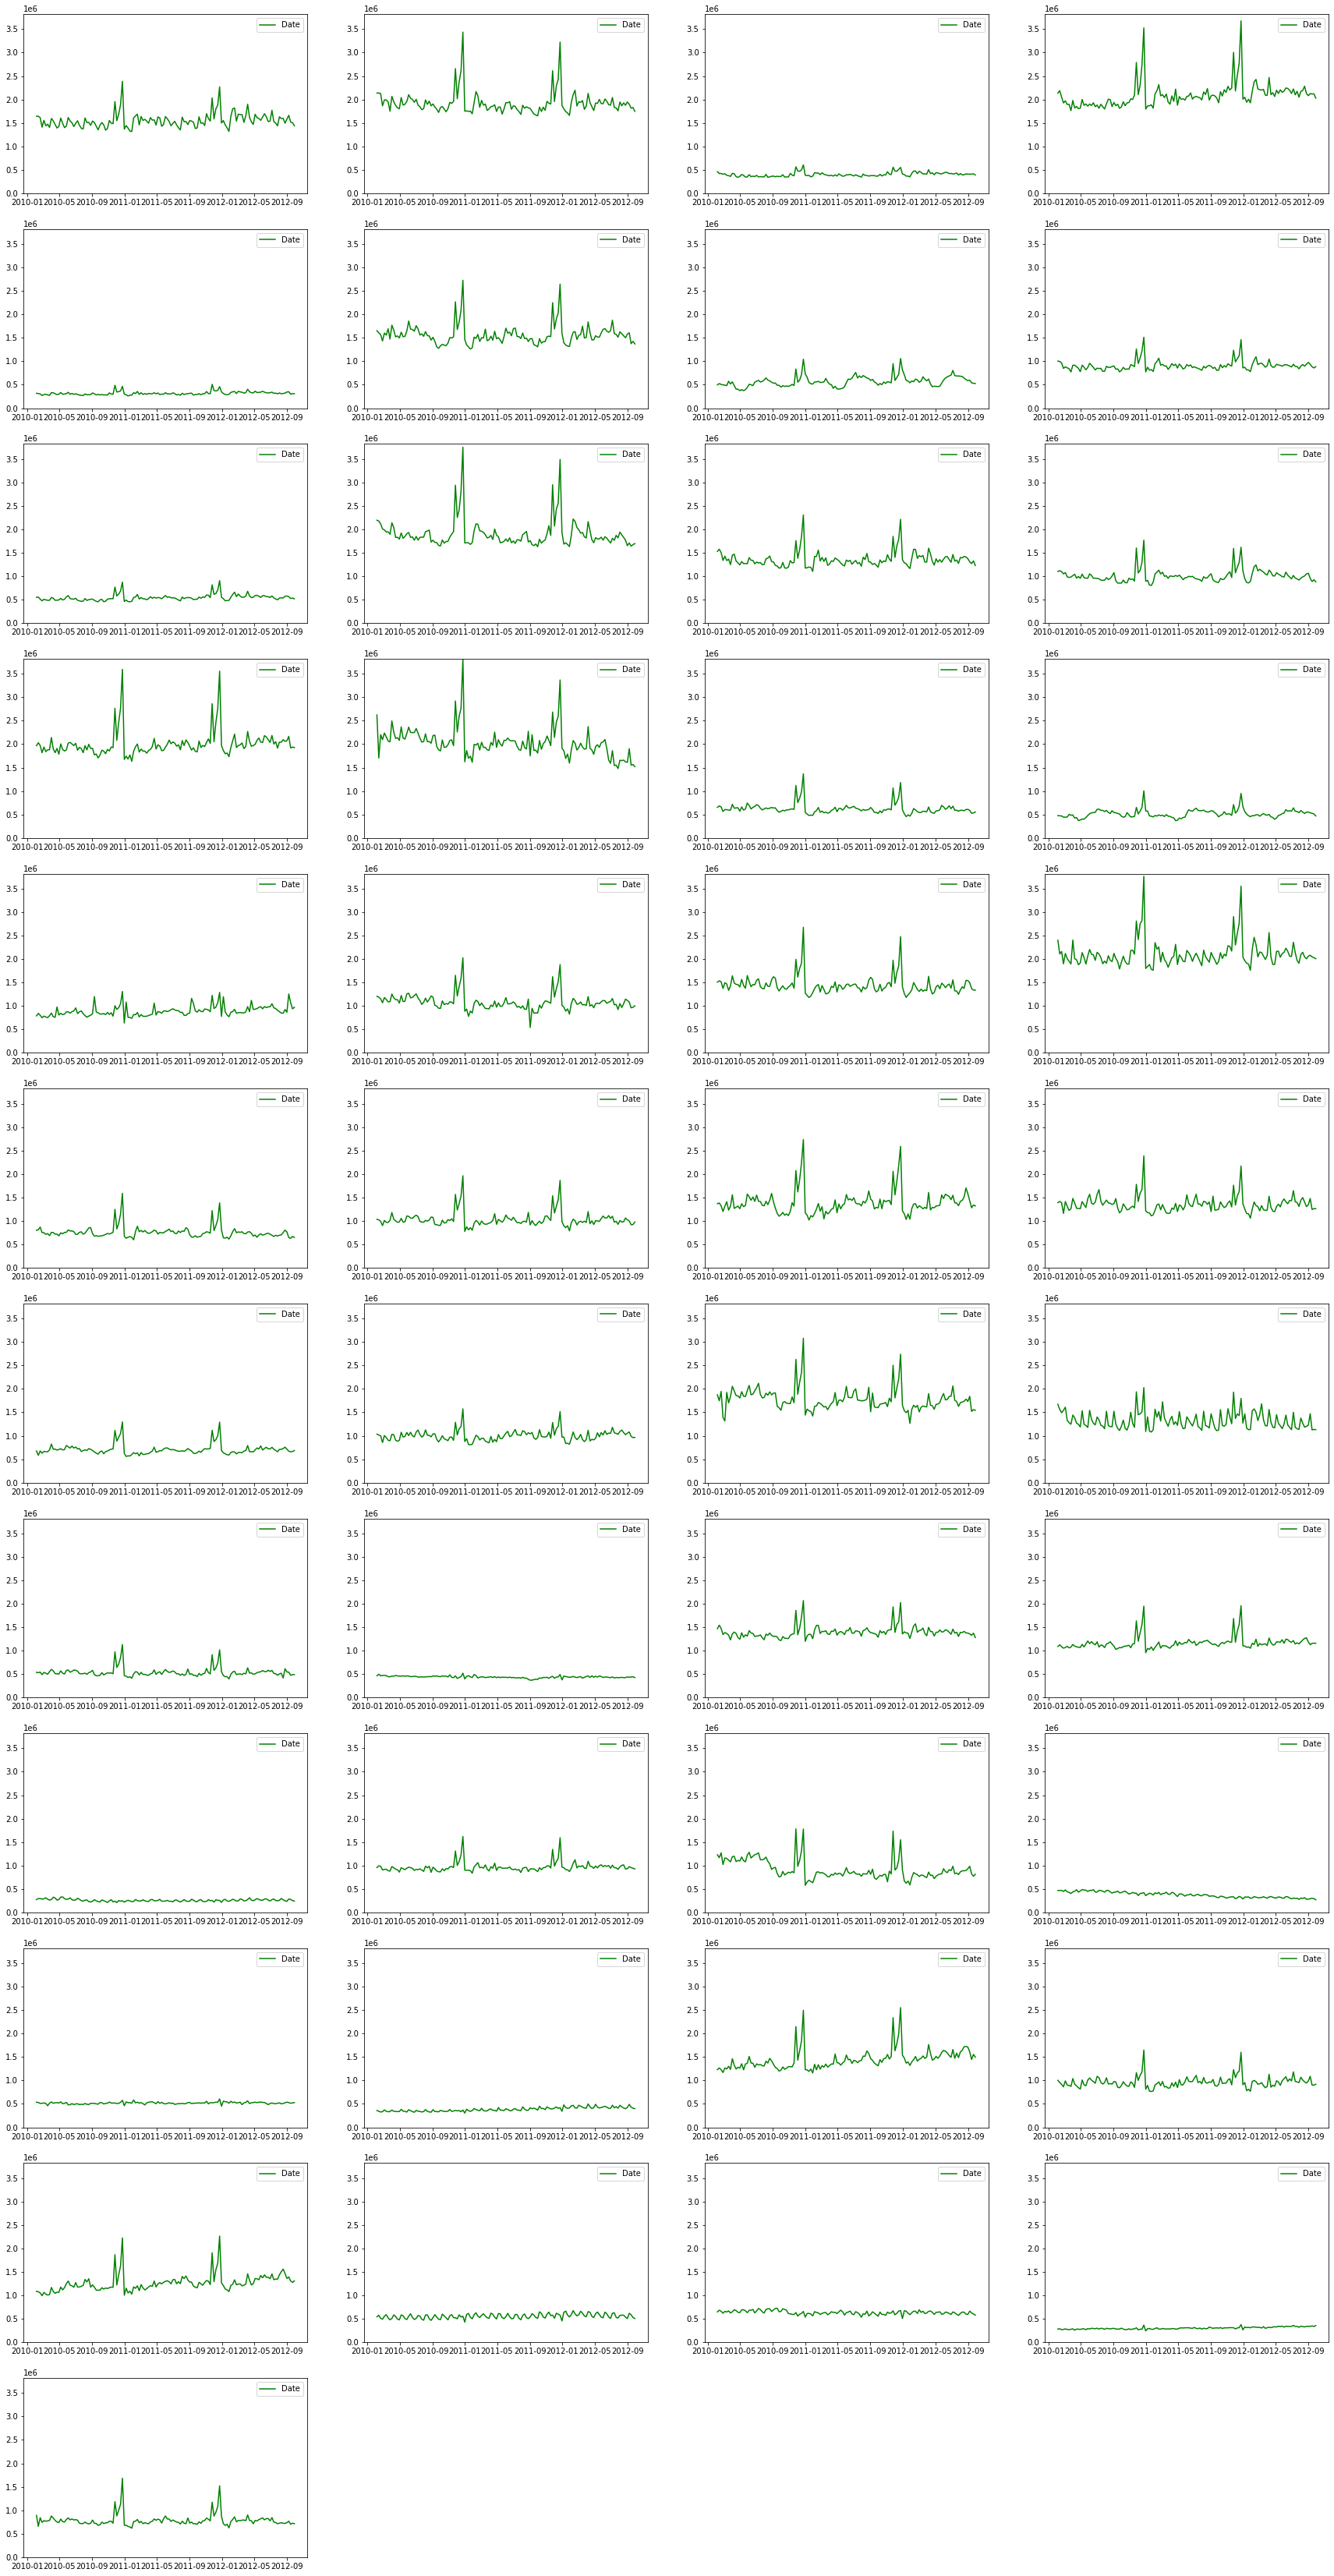

In [33]:
max_sales = max(train.Weekly_Sales)

fig = plt.figure(figsize=(30,60))
for store in range(1,max(train.Store)+1):
  storeset = train[train.Store==store]
  ax = fig.add_subplot(12, 4, store)
  ax.plot(storeset.Date, storeset.Weekly_Sales, label="Date", color='g')
  ax.legend()

  plt.ylim(0, max_sales)
plt.show()


대부분 지점의 판매량이 일정 시기에 많일 팔리는 패턴이다. 기간에 따른 반복이 진행된다.

**즉 연도에 따라 나눠서 진행해보자**

In [35]:
def dmychange(df):
  df['Date'] = df['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  df['Week'] = df.Date.dt.isocalendar().week.apply(lambda x: int(x))
  df['Day'] = df.Date.dt.day.apply(lambda x: int(x))
  df['Year'] = df.Date.dt.year.apply(lambda x: int(x))
  df['Month'] = df.Date.dt.month.apply(lambda x: int(x))
  df = df.drop(['Date'],axis=1)

  return df

연도기준으로 일정한 같은 파형을 그리기에 연도른 나눠서 어떤 연도가 더 잘 예측하는지 확인해보도록하자

In [ ]:
train_c= dmychange(train)
test_c= dmychange(test)

In [34]:
features = ['Store', 'NumberHoliday', 'Week', 'Day', 'Month', 'Year']

# 학습을 위한 하이퍼파라미터 설정
model_params = {
    "n_estimators": 60,
    "min_child_weight": 3,
    "max_depth": 6
}

for store in range(1,max(train.Store)+1):
    train_store = train[train.Store==store]
    
    # 2010, 2011, 2012 년도 별로 데이터 분리
    # 2012-09에 대해 예측하려고 하기 때문에 2012년도는 9월을 포함하지 않음
    train_store_2010 = train_store[(train_store.Year==2010) & (train_store.Month<=9)]
    train_store_2011 = train_store[(train_store.Year==2011) & (train_store.Month<=9)]
    train_store_2012 = train_store[(train_store.Year==2012) & (train_store.Month<9)]
    
    # 2011, 2010 년도를 제외한 데이터 생성
    train_store_2010_2012 = pd.concat([train_store_2010, train_store_2012])
    train_store_2011_2012 = pd.concat([train_store_2011, train_store_2012])
    
    # 각각의 모델 학습
    model_2010_2012 = xgboost.XGBRegressor(**model_params)
    model_2010_2012.fit(train_store_2010_2012[features],
                        train_store_2010_2012.Weekly_Sales)
    
    model_2011_2012 = xgboost.XGBRegressor(**model_params)
    model_2011_2012.fit(train_store_2011_2012[features],
                        train_store_2011_2012.Weekly_Sales)
    
    # 2012년도 9월에 대해서 예측
    x_test = train_store[(train_store.Year==2012) & (train_store.Month==9)]
    pred_2010_2012 = model_2010_2012.predict(x_test[features])
    pred_2011_2012 = model_2011_2012.predict(x_test[features])
    
    # 예측 결과 평가
    rmse_2010_2012 = RMSE(pred_2010_2012, x_test.Weekly_Sales)
    rmse_2011_2012 = RMSE(pred_2011_2012, x_test.Weekly_Sales)

    
    # 오차가 더 적은 연도를 선택
    similar_year = 2010
    if rmse_2010_2012 > rmse_2011_2012:
        similar_year = 2011

    print(f"{store:02}", similar_year, rmse_2010_2012, rmse_2011_2012)
    
    # 전체 데이터로 학습
    train_store_target = pd.concat([
        train_store[(train_store.Year==similar_year) & (train_store.Month<=10)],
        train_store[(train_store.Year==2012)]
    ])

    model = xgboost.XGBRegressor(**model_params)
    model.fit(train_store_target[features], train_store_target.Weekly_Sales)
        
    models.append(model)

NameError: ignored